<a href="https://colab.research.google.com/github/neil-vqa/Stock-price-trend-forecast/blob/master/forecast_univar_time_series_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import keras
import pandas as pd
import pandas_datareader as dr
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
stocks = ['AMZN']

df = dr.data.get_data_yahoo(stocks,start='2008-01', end='2019-01')

In [0]:
rs_data = df['Close'].resample('W').mean()
#rs_data.plot(figsize=(15,10));

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
sc_data = scaler.fit_transform(rs_data)

In [0]:
def init_data(sc_data):
  train_size = int(len(sc_data) * 0.80)
  test_size = len(sc_data) - train_size
  train_data, test_data = sc_data[0:train_size,:], sc_data[train_size:len(rs_data),:]
  
  return train_data, test_data, train_size

In [0]:
def data_gen(train_data,test_data):

  train_data_gen = keras.preprocessing.sequence.TimeseriesGenerator(train_data, train_data,
                                 length=10, sampling_rate=1,stride=1,
                                 batch_size=3)
  test_data_gen = keras.preprocessing.sequence.TimeseriesGenerator(test_data, test_data,
                               length=10, sampling_rate=1,stride=1,
                               batch_size=1)
  
  return train_data_gen, test_data_gen

In [0]:
def nn_model(train_data_gen):

  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(20, return_sequences=True, input_shape=(10, 1)))
  model.add(keras.layers.Dropout(rate=0.4))
  model.add(keras.layers.LSTM(20))
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(1))

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

  model.fit_generator(train_data_gen, epochs=50)
  
  return model

In [0]:
def predict(model, test_data_gen, train_size):
  
  testPredict = model.predict_generator(test_data_gen)
  testPredictor = scaler.inverse_transform(testPredict)
  testOrig = scaler.inverse_transform(sc_data[train_size + 10:len(rs_data),:])
  
  preds = [y for y in testPredictor]
  acts = [y for y in testOrig]
  
  return preds, acts, testPredict

In [0]:
def predictors(new_data, model):
  
  new_data_gen = keras.preprocessing.sequence.TimeseriesGenerator(new_data, new_data,
                               length=10, sampling_rate=1,stride=1,
                               batch_size=1)
  
  predictor = model.predict_generator(new_data_gen)
  
  return predictor

In [0]:
def forecaster(testPredict, model, n):
  
  hold_predict = testPredict
  forecasted = []
  i = 1
  while i <= n:
    new_data = hold_predict[-11:]
    new_predicted = predictors(new_data, model)
    hold_predict = np.vstack((hold_predict, new_predicted))
    inverted_predictor = scaler.inverse_transform(new_predicted)
    forecasted.append(inverted_predictor)
    i += 1
   
  return forecasted
    

In [0]:
def plot_pred(predicted_line, acts):

  plt.figure(figsize=(15,10))
  plt.plot(predicted_line, color='red', label='Predicted')
  plt.plot(acts, color='blue', label='Actual')
  plt.title('Weekly Stock Price Trend Forecast')
  plt.legend()
  plt.show()

In [0]:
initial_data = init_data(sc_data)

In [0]:
data_generated = data_gen(initial_data[0],initial_data[1])

In [0]:
lstm_model = nn_model(data_generated[0])

In [0]:
predicting_init = predict(lstm_model, data_generated[1], initial_data[2])

In [0]:
new_forecast = forecaster(predicting_init[2],lstm_model, 10)

In [0]:
predicted_line = predicting_init[0] + new_forecast

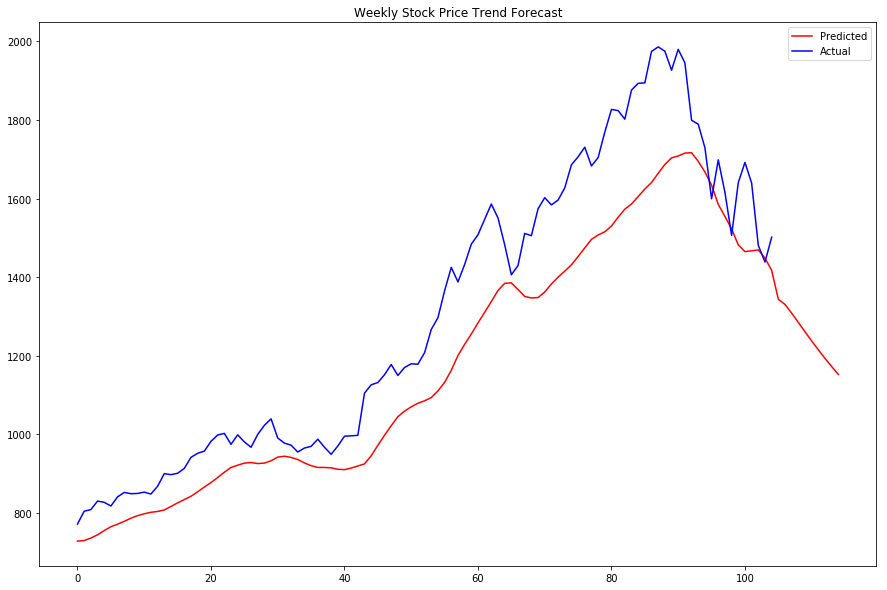

In [28]:
plotting = plot_pred(predicted_line, predicting_init[1])

In [0]:
print(len(predicted_line))
print(len(predicting_init[1]))

In [26]:
new_forecast

[array([[1344.0211]], dtype=float32),
 array([[1330.7614]], dtype=float32),
 array([[1308.6066]], dtype=float32),
 array([[1284.915]], dtype=float32),
 array([[1261.0961]], dtype=float32),
 array([[1237.781]], dtype=float32),
 array([[1215.1279]], dtype=float32),
 array([[1193.3162]], dtype=float32),
 array([[1172.4648]], dtype=float32),
 array([[1152.5719]], dtype=float32)]